In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import time
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v2

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def extract_face(image_path,show=False):
    image = Image.open(image_path)
    real_w,real_h = image.size
    bbox = open(image_path[:-4]+'_BB.txt').readlines()[0]

    bbox = [int(_) for _ in bbox.strip().split()[:4]]
    x1 = int(bbox[0]*(real_w / 224))
    y1 = int(bbox[1]*(real_h / 224))
    w1 = int(bbox[2]*(real_w / 224))
    h1 = int(bbox[3]*(real_h / 224))
    
    face = image.crop((x1, y1, x1 + w1, y1 + h1))
    if show:
        plt.imshow(face)
        plt.show()
#         plt.imshow(image)
    return face

In [4]:
data_dir = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/'
train_size = len(os.listdir(os.path.join(data_dir, 'train')))
test_size = len(os.listdir(os.path.join(data_dir, 'test')))

print('train: {}; test: {}'.format(train_size, test_size))

train: 8192; test: 1004


In [5]:
path_train_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/train_label.json'
path_test_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/test_label.json'
path_local = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/'

In [6]:
df_train = pd.read_json(path_train_json, orient='index')
df_test = pd.read_json(path_test_json, orient='index')

df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train.rename(columns={'index': 'Filepath'}, inplace=True)
df_test.rename(columns={'index': 'Filepath'}, inplace=True)

In [7]:
df_train['Filepath'] = df_train['Filepath'].apply(lambda x: path_local +  x)
df_test['Filepath'] = df_test['Filepath'].apply(lambda x: path_local  + x)

In [8]:
df_train

,Filepath,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
0,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,1,1
2,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,1,1
3,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,2,1
4,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494400,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,1
494401,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,2,1
494402,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
494403,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,2,1


In [9]:
invalid_file_name = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/3329/spoof/004046.jpg'

df_train.drop(df_train[df_train['Filepath']==invalid_file_name].index, inplace=True)
df_train

,Filepath,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
0,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,1,1
2,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,1,1
3,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,2,1
4,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494400,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,1
494401,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,2,1
494402,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
494403,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,2,1


In [10]:
df_train.Filepath[0]

'/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/2623/live/000000.jpg'

In [11]:
# load bounding box
bbox = np.loadtxt(df_train.Filepath[15][:-4] + '_BB.txt')
bbox

array([ 63.       ,  54.       ,  92.       , 112.       ,   0.9990876])

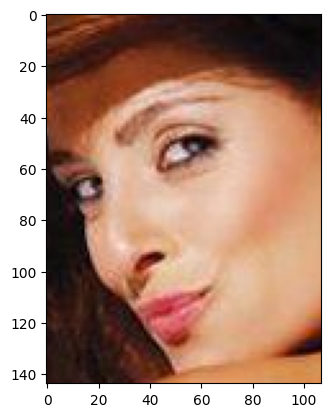

In [12]:
face = extract_face(df_train.Filepath[0], show=True)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using \'{}\' device'.format(device))
model = mobilenet_v2(pretrained=True)
# modify the final layer to output 2 classes (live/spoof)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = model.to(device)

using 'cuda' device


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.2MB/s]


In [14]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
# transformations
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [16]:
# prepare data
class FASDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Filepath']
        bbox_path = img_path[:-4] + '_BB.txt'
                
        cropped = extract_face(img_path)
        label = df_train.iloc[idx][43]
        
        if self.transforms is not None:
            

            image = self.transforms(cropped)
            
        return image, label

In [17]:
df_train[43].value_counts()

43
1    331942
0    162462
Name: count, dtype: int64

In [18]:
# down sample the size of trainning set
df_train_sample = df_train.sample(frac=0.005, random_state=43)
df_train_sample[43].value_counts()

43
1    1673
0     799
Name: count, dtype: int64

In [19]:
df_1 = df_train_sample[df_train_sample[43]==1][:799]
df_2 = df_train_sample[df_train_sample[43]==0][:799]
df_train_sample_balanced = pd.concat([df_1, df_2])
df_train_sample_balanced = df_train_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
df_train_sample_balanced[43].value_counts()

43
0    799
1    799
Name: count, dtype: int64

In [21]:
train_dataset = FASDataset(df_train_sample_balanced, transforms['train'])
dataloader_train = DataLoader(train_dataset, batch_size=32)

In [22]:
print('length of dataset = ', len(train_dataset), '\n')
img, label = next(iter(dataloader_train))
img.size(), label.size()

length of dataset =  1598 



(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [23]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader_train):.4f}")


Epoch 1/100: 100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


Epoch [1/100], Loss: 0.7026


Epoch 2/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [2/100], Loss: 0.6566


Epoch 3/100: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Epoch [3/100], Loss: 0.6590


Epoch 4/100: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch [4/100], Loss: 0.6497


Epoch 5/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [5/100], Loss: 0.6497


Epoch 6/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [6/100], Loss: 0.6453


Epoch 7/100: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


Epoch [7/100], Loss: 0.6464


Epoch 8/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [8/100], Loss: 0.6640


Epoch 9/100: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Epoch [9/100], Loss: 0.6455


Epoch 10/100: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch [10/100], Loss: 0.6468


Epoch 11/100: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


Epoch [11/100], Loss: 0.6430


Epoch 12/100: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Epoch [12/100], Loss: 0.6428


Epoch 13/100: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Epoch [13/100], Loss: 0.6398


Epoch 14/100: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Epoch [14/100], Loss: 0.6414


Epoch 15/100: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Epoch [15/100], Loss: 0.6382


Epoch 16/100: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Epoch [16/100], Loss: 0.6418


Epoch 17/100: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


Epoch [17/100], Loss: 0.6416


Epoch 18/100: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch [18/100], Loss: 0.6435


Epoch 19/100: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch [19/100], Loss: 0.6409


Epoch 20/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [20/100], Loss: 0.6384


Epoch 21/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [21/100], Loss: 0.6386


Epoch 22/100: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Epoch [22/100], Loss: 0.6365


Epoch 23/100: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Epoch [23/100], Loss: 0.6377


Epoch 24/100: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Epoch [24/100], Loss: 0.6375


Epoch 25/100: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch [25/100], Loss: 0.6387


Epoch 26/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [26/100], Loss: 0.6397


Epoch 27/100: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Epoch [27/100], Loss: 0.6333


Epoch 28/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [28/100], Loss: 0.6384


Epoch 29/100: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch [29/100], Loss: 0.6382


Epoch 30/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [30/100], Loss: 0.6389


Epoch 31/100: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch [31/100], Loss: 0.6386


Epoch 32/100: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Epoch [32/100], Loss: 0.6370


Epoch 33/100: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch [33/100], Loss: 0.6354


Epoch 34/100: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Epoch [34/100], Loss: 0.6375


Epoch 35/100: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


Epoch [35/100], Loss: 0.6341


Epoch 36/100: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Epoch [36/100], Loss: 0.6361


Epoch 37/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [37/100], Loss: 0.6315


Epoch 38/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [38/100], Loss: 0.6354


Epoch 39/100: 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


Epoch [39/100], Loss: 0.6340


Epoch 40/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [40/100], Loss: 0.6350


Epoch 41/100: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch [41/100], Loss: 0.6338


Epoch 42/100: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Epoch [42/100], Loss: 0.6344


Epoch 43/100: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch [43/100], Loss: 0.6324


Epoch 44/100: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch [44/100], Loss: 0.6351


Epoch 45/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [45/100], Loss: 0.6327


Epoch 46/100: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Epoch [46/100], Loss: 0.6353


Epoch 47/100: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Epoch [47/100], Loss: 0.6327


Epoch 48/100: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch [48/100], Loss: 0.6371


Epoch 49/100: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Epoch [49/100], Loss: 0.6330


Epoch 50/100: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Epoch [50/100], Loss: 0.6304


Epoch 51/100: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch [51/100], Loss: 0.6268


Epoch 52/100: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Epoch [52/100], Loss: 0.6339


Epoch 53/100: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Epoch [53/100], Loss: 0.6345


Epoch 54/100: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Epoch [54/100], Loss: 0.6297


Epoch 55/100: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch [55/100], Loss: 0.6311


Epoch 56/100: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Epoch [56/100], Loss: 0.6322


Epoch 57/100: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Epoch [57/100], Loss: 0.6340


Epoch 58/100: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch [58/100], Loss: 0.6361


Epoch 59/100: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Epoch [59/100], Loss: 0.6352


Epoch 60/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [60/100], Loss: 0.6363


Epoch 61/100: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch [61/100], Loss: 0.6348


Epoch 62/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [62/100], Loss: 0.6347


Epoch 63/100: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Epoch [63/100], Loss: 0.6312


Epoch 64/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [64/100], Loss: 0.6344


Epoch 65/100: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch [65/100], Loss: 0.6311


Epoch 66/100: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch [66/100], Loss: 0.6309


Epoch 67/100: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Epoch [67/100], Loss: 0.6295


Epoch 68/100: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Epoch [68/100], Loss: 0.6309


Epoch 69/100: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch [69/100], Loss: 0.6323


Epoch 70/100: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch [70/100], Loss: 0.6340


Epoch 71/100: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Epoch [71/100], Loss: 0.6350


Epoch 72/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [72/100], Loss: 0.6294


Epoch 73/100: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch [73/100], Loss: 0.6336


Epoch 74/100: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Epoch [74/100], Loss: 0.6375


Epoch 75/100: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Epoch [75/100], Loss: 0.6293


Epoch 76/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [76/100], Loss: 0.6326


Epoch 77/100: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch [77/100], Loss: 0.6333


Epoch 78/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [78/100], Loss: 0.6286


Epoch 79/100: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch [79/100], Loss: 0.6307


Epoch 80/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [80/100], Loss: 0.6261


Epoch 81/100: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch [81/100], Loss: 0.6276


Epoch 82/100: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Epoch [82/100], Loss: 0.6219


Epoch 83/100: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Epoch [83/100], Loss: 0.6243


Epoch 84/100: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch [84/100], Loss: 0.6263


Epoch 85/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [85/100], Loss: 0.6281


Epoch 86/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [86/100], Loss: 0.6280


Epoch 87/100: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Epoch [87/100], Loss: 0.6248


Epoch 88/100: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch [88/100], Loss: 0.6277


Epoch 89/100: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch [89/100], Loss: 0.6199


Epoch 90/100: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch [90/100], Loss: 0.6286


Epoch 91/100: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Epoch [91/100], Loss: 0.6251


Epoch 92/100: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch [92/100], Loss: 0.6441


Epoch 93/100: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Epoch [93/100], Loss: 0.6415


Epoch 94/100: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch [94/100], Loss: 0.6353


Epoch 95/100: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Epoch [95/100], Loss: 0.6279


Epoch 96/100: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch [96/100], Loss: 0.6266


Epoch 97/100: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Epoch [97/100], Loss: 0.6273


Epoch 98/100: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch [98/100], Loss: 0.6241


Epoch 99/100: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Epoch [99/100], Loss: 0.6274


Epoch 100/100: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]

Epoch [100/100], Loss: 0.6234


In [25]:

# Save the model weights
model_save_path = '/kaggle/working/mobilenetv2_weights.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

Model weights saved to /kaggle/working/mobilenetv2_weights.pth


In [26]:
# os.listdir('/kaggle/input/fas_mn2/pytorch/v1/2')

In [27]:
# pretrain_weights = '/kaggle/input/fas_mn2/pytorch/v1/2/mobilenetv2_weights.pth'

In [28]:
# test_dataset = FASDataset(df_test, transforms['test'])
# dataloader_test = DataLoader(test_dataset, batch_size=32)

In [29]:
# model = mobilenet_v2()
# # modify the final layer to output 2 classes (live/spoof)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

In [30]:
# model.load_state_dict(torch.load(pretrain_weights))
# model.to(device)
# model.eval()

In [31]:
# with torch.no_grad():
#     for inputs, labels in tqdm(dataloader_test):
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         print(labels)
#         print(outputs)
#         print(outputs.size())
        
#         probs = torch.nn.functional.softmax(outputs, dim=1)
#         print(probs)
#         predicted_class = torch.argmax(probs, dim=1)
#         print(predicted_class)
#         break

In [32]:
# # Initialize variables to track the number of correct predictions and total samples
# correct = 0
# total = 0

# # Disable gradient calculation for evaluation
# with torch.no_grad():
#     progress_bar = tqdm(dataloader_test)
#     for inputs, labels in progress_bar:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Get model outputs
#         outputs = model(inputs)
        
#         # Compute probabilities using softmax
#         probs = torch.nn.functional.softmax(outputs, dim=1)
        
#         # Get the predicted class
#         predicted_class = torch.argmax(probs, dim=1)
        
#         # Update the total number of samples
#         total += labels.size(0)
        
#         # Update the number of correct predictions
#         correct += (predicted_class == labels).sum().item()
#         # Calculate the accuracy
#         accuracy = correct / total
#         progress_bar.set_postfix({'acc': accuracy})

# # Calculate the accuracy
# accuracy = correct / total

# print(f'Accuracy: {accuracy * 100:.2f}%')